# 

## Question 1

1) You need to implement the perceptron algorithm without regularization (don’t use any existing implementation of perceptron), train it on the 20 points above, and test its accuracy on 1000 randomly generated points inside the unit square. Generate the test points using the same procedure as the
training points. You need to have your own implementation of the perceptron algorithm.

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from keras import initializers
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras import backend as K
from matplotlib import pyplot as plt
from matplotlib import rcParamsDefault
from keras import models
from keras import layers
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras import models, layers
from keras.utils import np_utils
from keras.layers import BatchNormalization
import seaborn as sns
import random
import time
from sklearn.metrics import mean_squared_error
from collections import defaultdict
from numpy.core.fromnumeric import mean

Using TensorFlow backend.


In [ ]:
def label(a):
  b=[]
  for c in a:
    if c[0]>c[1]:
      b.append(1)
    else:
      b.append(-1)
  return b

def model_train(epochs,alpha,data,labels,a):
  np.random.seed(10)
  w=np.random.rand(1,2)[0]
  for i in range(epochs):
    for x,l in zip(data,labels):
      y_hat = np.dot(x,w)
      if y_hat*l<a:
        w=w+alpha*x*l
  return w

def acc(y_pred,label):
  sum=0
  for i in range(len(y_pred)):
    if y_pred[i]==label[i]:
      sum+=1
  return sum/len(y_hat)

In [ ]:
X_train = np.random.rand(20,2)
X_test = np.random.rand(1000,2)
ls=label(X_train)
true=label(X_test)

In [ ]:
w = model_train(100,1,X_train,ls,0)
y_hat = np.sign(np.dot(X_train,w))
acc_p=acc(y_hat,true)
print('Accuracy of perceptron criterion', acc_p)

Accuracy of perceptron criterion 0.93


2) Change the perceptron criterion to hinge-loss in your implementation for training, and repeat the
accuracy computation on the same test points above. Regularization is not used.

In [ ]:
w2 = model_train(100,1,X_train,ls,1)
y_hat2 = np.sign(np.dot(X_train,w2))
acc_h=acc(y_hat2,true)
print('Accuracy of hinge loss criterion', acc_h)

Accuracy of hinge loss criterion 0.983


3) In which case do you obtain better accuracy and why? 

The hinge-loss perceptron performs better most of the time compared to the normal perceptron criterion, since correctly classified points also contribute to the loss function thereby leading to maximum seperation

4) In which case do you think that the classification of the same 1000 test instances will not change
significantly by using a different set of 20 training points?

The hinge-loss perceptron criterion will not change much using a different set of 20 training points, since this criterion makes it so that we have maximal separation. The normal perceptron algorithm's decision boundary relies on the training set.

## Question 2

1) Explain vanishing gradients phenomenon using standard normalization with different values of standard
deviation and tanh and sigmoid activation functions. Then show how Xavier (aka Glorot normal)
initialization of weights helps in dealing with this problem. Next use ReLU activation and show that
instead of Xavier initialization, He initialization works better for ReLU activation. You can plot
activations at each of the 5 layers to answer this question. 

###Utils

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras import backend as K

from matplotlib import pyplot as plt
from matplotlib import rcParamsDefault


def grid_axes_it(n_plots, n_cols=3, enumerate=False, fig=None):
    """
    Iterate through Axes objects on a grid with n_cols columns and as many
    rows as needed to accommodate n_plots many plots.

    Args:
        n_plots: Number of plots to plot onto figure.
        n_cols: Number of columns to divide the figure into.
        fig: Optional figure reference.

    Yields:
        n_plots many Axes objects on a grid.
    """
    n_rows = n_plots / n_cols + int(n_plots % n_cols > 0)

    if not fig:
        default_figsize = rcParamsDefault['figure.figsize']
        fig = plt.figure(figsize=(
            default_figsize[0] * n_cols,
            default_figsize[1] * n_rows
        ))

    for i in range(1, n_plots + 1):
        ax = plt.subplot(n_rows, n_cols, i)
        yield ax


def create_mlp_model(
    n_hidden_layers,
    dim_layer,
    input_shape,
    n_classes,
    kernel_initializer,
    bias_initializer,
    activation,
):
    """Create Multi-Layer Perceptron with given parameters."""
    model = Sequential()
    model.add(Dense(dim_layer, input_shape=input_shape, kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    for i in range(n_hidden_layers):
        model.add(Dense(dim_layer, activation=activation, kernel_initializer=kernel_initializer,
                        bias_initializer=bias_initializer))
    model.add(Dense(n_classes, activation='softmax', kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    return model


def create_cnn_model(input_shape, num_classes, kernel_initializer='glorot_uniform',
                     bias_initializer='zeros'):
    """Create CNN model similar to
       https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py."""
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,
                     kernel_initializer=kernel_initializer,
                     bias_initializer=bias_initializer))
    model.add(Conv2D(64, (3, 3), activation='relu',
                     kernel_initializer=kernel_initializer,
                     bias_initializer=bias_initializer))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu',
                    kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax',
                    kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    return model


def compile_model(model):
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.RMSprop(),
                  metrics=['accuracy'])
    return model


def get_init_id(init):
    """
    Returns string ID summarizing initialization scheme and its parameters.

    Args:
        init: Instance of some initializer from keras.initializers.
    """
    try:
        init_name = str(init).split('.')[2].split(' ')[0]
    except:
        init_name = str(init).split(' ')[0].replace('.', '_')

    param_list = []
    config = init.get_config()
    for k, v in config.items():
        if k == 'seed':
            continue
        param_list.append('{k}-{v}'.format(k=k, v=v))
    init_params = '__'.join(param_list)

    return '|'.join([init_name, init_params])


def get_activations(model, x, mode=0.0):
    """Extract activations with given model and input vector x."""
    outputs = [layer.output for layer in model.layers]
    activations = K.function([model.input], outputs)
    output_elts = activations([x, mode])
    return output_elts


class LossHistory(keras.callbacks.Callback):
    """A custom keras callback for recording losses during network training."""

    def on_train_begin(self, logs={}):
        self.losses = []
        self.epoch_losses = []
        self.epoch_val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

    def on_epoch_end(self, epoch, logs={}):
        self.epoch_losses.append(logs.get('loss'))
        self.epoch_val_losses.append(logs.get('val_loss'))
        

In [ ]:
# Network To Train Params
hidden_layers_num = 5
nodes_in_layer = 100
batch_size = 1000
epochs = 1

# MNIST Dataset Related
train_num = 60000
test_num = 10000

(x_train, y_train), (x_test, y_test) = mnist.load_data()
classes_num = len(np.unique(y_test))
pixels_num_data = 28*28

x_train = x_train.reshape(train_num, pixels_num_data).astype('float32')[:train_num]
x_test = x_test.reshape(test_num, pixels_num_data).astype('float32')[:test_num]
x_train /= 255
x_test /= 255

y_train = keras.utils.to_categorical(y_train, classes_num)
y_test = keras.utils.to_categorical(y_test, classes_num)

In [ ]:
def draw_activations_plots(rows_activations, sigmas, initializer_type, activation_func_name):
  df = pd.DataFrame(rows_activations, columns=['Hidden Layer', 'Standard Deviation', 'Output'])
  fig = plt.figure(figsize=(12, 4*len(sigmas)))
  axes = grid_axes_it(len(sigmas), 1, fig=fig)

  for sig in sigmas:
    ax = next(axes)
    ddf = df[df['Standard Deviation'] == sig]
    sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

    ax.set_xlabel('')
    ax.set_ylabel('')

    if initializer_type == "Random Normal":
      ax.set_title('Activations Drawn from $N(\mu = 0, \sigma = {%.4f})$' % sig, fontsize=13)
    elif initializer_type == "Xavier" or initializer_type == "He":
      ax.set_title(f'Activations Drawn from {initializer_type} Initialization', fontsize=12)
    
    if (len(sigmas) > 1 and sig == sigmas[1]) or len(sigmas) == 1:
      ax.set_ylabel(f"{activation_func_name} Neuron Outputs")
    if sig != sigmas[-1]:
      ax.set_xticklabels(())
    else:
      ax.set_xlabel("Hidden Layer")

  plt.tight_layout()
  plt.show()

def create_and_train_model(rows, stddev, init_handler, activation_func):
  model = create_mlp_model(hidden_layers_num, nodes_in_layer, (pixels_num_data,), classes_num, init_handler, 'zeros', activation_func)
  compile_model(model)
  model.fit(x_train, y_train, epochs=epochs, verbose = 0, batch_size=batch_size)

  output_elts = get_activations(model, x_test)
  n_layers = len(model.layers)
  i_output_layer = n_layers - 1

  for i, out in enumerate(output_elts[:-1]):
    if i > 0 and i != i_output_layer:
      for out_i in out.ravel()[::20]:
        rows.append([i, stddev, out_i])

  return rows

In [ ]:
def run(sigmas, initializer_type, activation_func, activation_func_name):
  rows_activations = []

  if initializer_type == "Random Normal":
    for stddev in sigmas:
      init_handler = initializers.RandomNormal(mean=0.0, stddev=stddev)
      rows_activations = create_and_train_model(rows_activations, stddev, init_handler, activation_func)
  elif initializer_type == "Xavier":
    init_handler = initializers.glorot_normal()
    rows_activations = create_and_train_model(rows_activations, sigmas[0], init_handler, activation_func)
  elif initializer_type == "He":
    init_handler = initializers.he_normal()
    rows_activations = create_and_train_model(rows_activations, sigmas[0], init_handler, activation_func)
  
  draw_activations_plots(rows_activations, sigmas, initializer_type, activation_func_name)

### Normal- Tanh

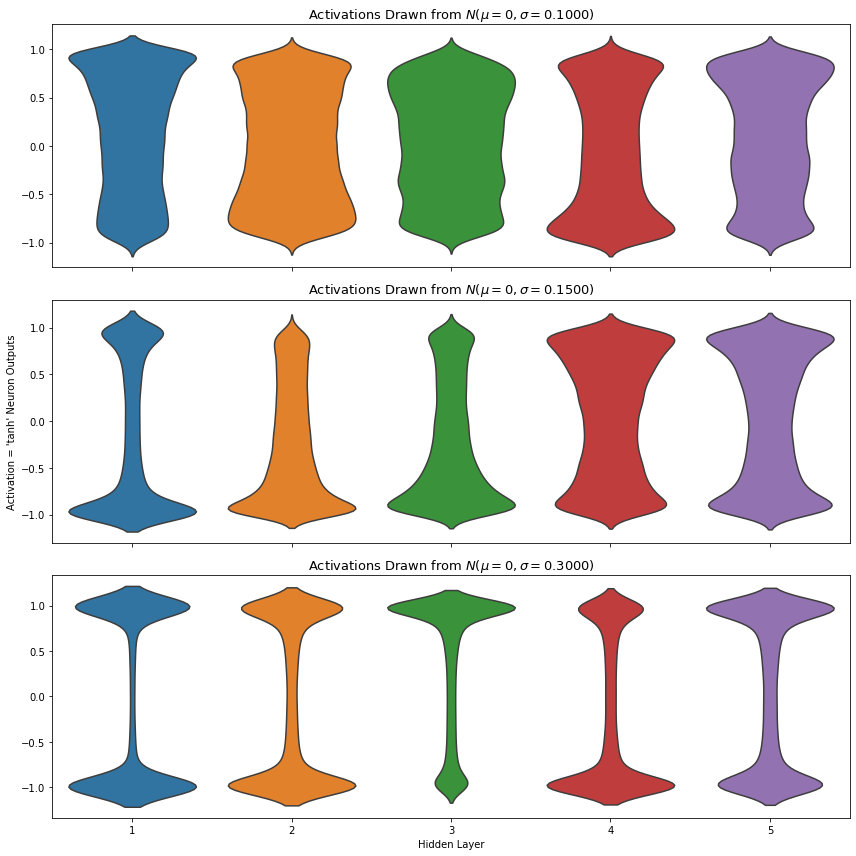

In [ ]:
rows_activations = run([0.1, 0.15, 0.3], "Random Normal", 'tanh', 'Activation = \'tanh\'')

### Normal- sigmoid

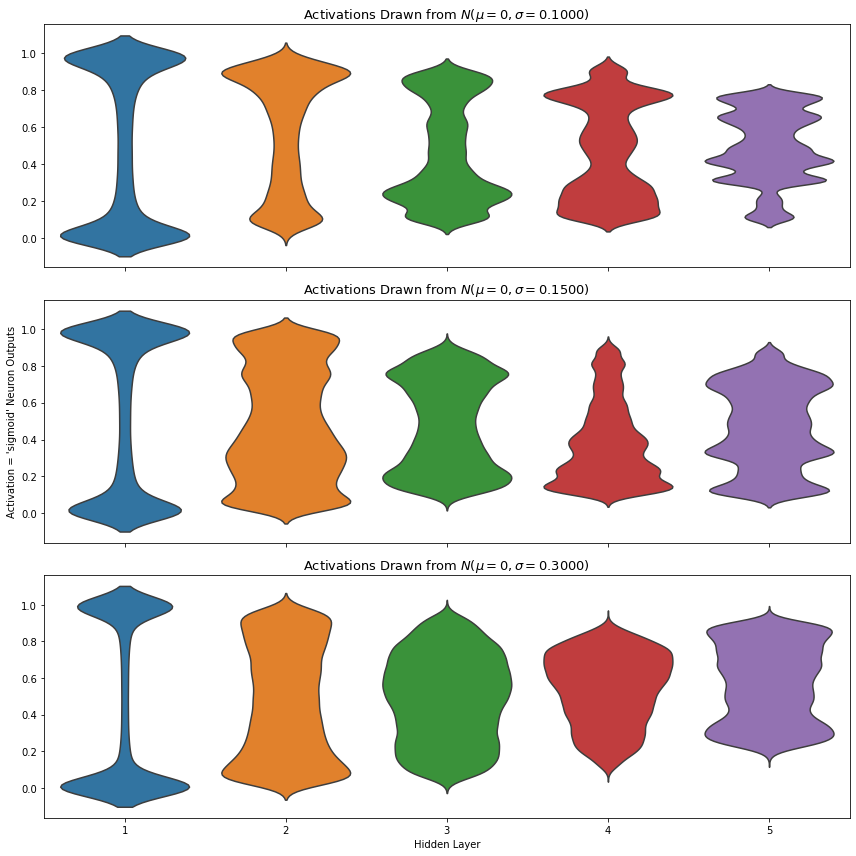

In [ ]:
run([0.1, 0.15, 0.3], "Random Normal", 'sigmoid', 'Activation = \'sigmoid\'')

### Xavier - Tanh

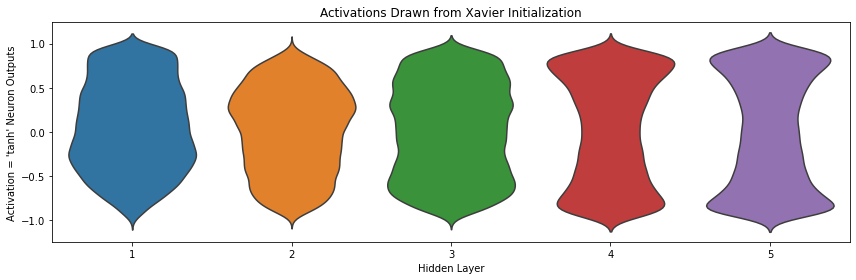

In [ ]:
run([1], "Xavier", 'tanh', 'Activation = \'tanh\'')

### Xavier - sigmoid

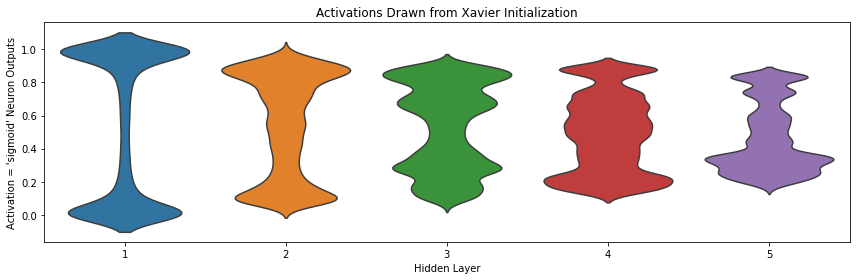

In [ ]:
run([1], "Xavier", 'sigmoid', 'Activation = \'sigmoid\'')

### Xavier - Relu

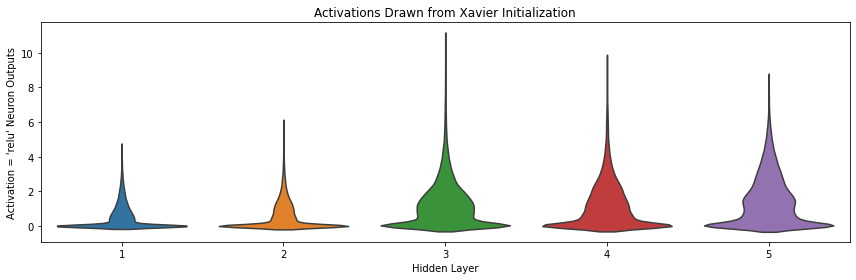

In [ ]:
run([1], "Xavier", 'relu', 'Activation = \'relu\'')

### He - Relu

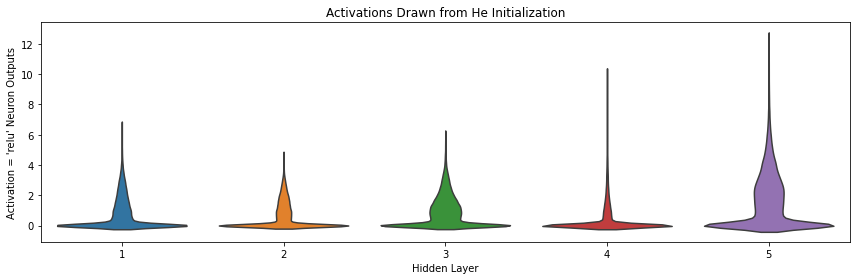

In [ ]:
run([1], "He", 'relu', 'Activation = \'relu\'')

As seen above, the vanishing gradient problem is eliminated when using the He initialization. The gradients are not vanishing as a good range of activation values are observed. This proves that He works better than Xavier when it comes to dealing with vanishing gradients

2) The dying ReLU is a kind of vanishing gradient, which refers to a problem when ReLU neurons become
inactive and only output 0 for any input. In the worst case of dying ReLU, ReLU neurons at a certain
layer are all dead, i.e., the entire network dies and is referred as the dying ReLU neural networks in
Lu et al (reference below). A dying ReLU neural network collapses to a constant function. Show this
phenomenon using any one of the three 1-dimensional functions in page 11 of Lu et al. Use a 10-layer
ReLU network with width 2 (hidden units per layer). Use minibatch of 64 and draw training data
uniformly from [−√7,√7]. Perform 1000 independent training simulations each with 3,000 training
points. Out of these 1000 simulations, what fraction resulted in neural network collapse. Is your
answer close to over 90% as was reported in Lu et al. ?

In [ ]:
np.random.seed(42)
x = np.random.uniform(-np.sqrt(7),np.sqrt(7),3000)
x = x.reshape(-1,1)
y = abs(x)
y = y.reshape(-1,1)

xt = np.random.uniform(-np.sqrt(7),np.sqrt(7),750)
xt = xt.reshape(-1,1)
yt = abs(x)
yt = yt.reshape(-1,1)

init = initializers.he_normal()


model = keras.Sequential()
for i in range(9):
    model.add(Dense(2, activation='relu', kernel_initializer=init))
model.add(layers.Dense(1))
model.build((1,1))
model.compile(loss='mse', optimizer='adam')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
count=0
for i in range(1000):
  hist = model.fit(x=x,y=y, epochs=10, batch_size=64, verbose=0)
  pred = model.predict(xt)
  if len(set(pred.reshape(750)))==1 :
         count+=1
print(count/1000*100)


100.0


All the iterations led to models dying and predicting a constant value. 

In [ ]:
from keras.layers import LeakyReLU

In [ ]:
model = keras.Sequential()

for i in range(9):
    model.add(Dense(2, kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.01))
model.add(layers.Dense(1))
model.compile(loss='mse', optimizer='adam')

In [ ]:
count=0
for i in range(1000):
  hist = model.fit(x=x,y=y, epochs=10, batch_size=64, verbose=0)
  pred = model.predict(xt)
  if len(set(pred.reshape(750)))==1:
    count+=1
print(count/1000*100)

0.0


It has completely eliminated the possibility of a dying Relu network. All the iterations led to the model giving different outputs indicating the absence of dying units

## Question 3

1) Explain the terms co-adaptation and internal covariance-shift. Use examples if needed. You may need
to refer to two papers mentioned below to answer this question. 

When distinct hidden units in a neural network have highly correlated behavior, this is referred to as co-adaptation. Hidden units that can identify characteristics independently of each other are better for computational efficiency and the model's capacity to learn a general representation. Dropout is one of the regularization strategies that aims to reduce co-adapatation. Internal Covariate Shift is defined as the shift in network activation distribution caused by changes in network parameters during training. Batch normalization is a strategy for neural networks to reduce internal covariate shift.

2) Batch normalization is traditionally used in hidden layers, for input layer standard normalization is
used. In standard normalization the mean and standard deviation are calculated using the entire
training dataset whereas in batch normalization these statistics are calculated for each mini-batch.
Train LeNet-5 with standard normalization of input and batch normalization for hidden layers. What
are the learned batch norm parameters for each layer ?

In [ ]:
from keras.layers import MaxPooling2D
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

y_train = keras.utils.np_utils.to_categorical(y_train, 10)
y_test = keras.utils.np_utils.to_categorical(y_test, 10)

x_train = x_train.reshape(x_train.shape[0], 28,28,1)
x_test = x_test.reshape(x_test.shape[0], 28,28,1)

In [ ]:
model = Sequential()

model.add(layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(28,28,1)))
tf.keras.layers.LayerNormalization(trainable=True)
model.add(MaxPooling2D(pool_size = 2, strides = 2))
model.add(layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh'))
model.add(BatchNormalization(trainable=True))
model.add(MaxPooling2D(pool_size = 2, strides = 2))
model.add(layers.Flatten())
model.add(layers.Dense(120, activation='tanh'))
model.add(BatchNormalization(trainable=True))
model.add(layers.Dense(84, activation='tanh'))
model.add(BatchNormalization(trainable=True))
model.add(layers.Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = model.fit(x=x_train,y=y_train, epochs=10, batch_size=128, verbose=1)
test_score = model.evaluate(x_test, y_test)
print('Test loss {:.4f}, accuracy {:.2f}%'.format(test_score[0], test_score[1] * 100))

Epoch 1/10
60000/60000 [==============================] - 15s 255us/step - loss: 0.1879 - accuracy: 0.9439
Epoch 2/10
60000/60000 [==============================] - 7s 114us/step - loss: 0.0631 - accuracy: 0.9806
Epoch 3/10
60000/60000 [==============================] - 6s 107us/step - loss: 0.0416 - accuracy: 0.9868
Epoch 4/10
60000/60000 [==============================] - 10s 166us/step - loss: 0.0322 - accuracy: 0.9894
Epoch 5/10
60000/60000 [==============================] - 6s 98us/step - loss: 0.0265 - accuracy: 0.9916
Epoch 6/10
60000/60000 [==============================] - 6s 98us/step - loss: 0.0211 - accuracy: 0.9932
Epoch 7/10
60000/60000 [==============================] - 6s 99us/step - loss: 0.0173 - accuracy: 0.9947
Epoch 8/10
60000/60000 [==============================] - 6s 98us/step - loss: 0.0144 - accuracy: 0.9955
Epoch 9/10
60000/60000 [==============================] - 6s 96us/step - loss: 0.0136 - accuracy: 0.9956
Epoch 10/10
10000/10000 [========================

In [ ]:
print('First gamma parameters: ',model.get_weights()[4])
print('First beta parameters: ',model.get_weights()[5])
print('First mean parameters: ',model.get_weights()[6])
print('First std parameters: ',model.get_weights()[7])
print('Second gamma parameters: ',model.get_weights()[10])
print('Second beta parameters: ',model.get_weights()[11])
print('Second mean parameters: ',model.get_weights()[12])
print('Second std parameters: ',model.get_weights()[13])
print('Third gamma parameters: ',model.get_weights()[16])
print('Third beta parameters: ',model.get_weights()[17])
print('Third mean parameters: ',model.get_weights()[18])
print('Third std parameters: ',model.get_weights()[19])

First gamma parameters:  [0.89549077 0.86043227 1.0016594  0.8627748  1.0369712  0.86291933
 0.9998072  1.0586317  0.9422966  0.9142139  0.9818344  0.873098
 0.9355277  1.0733877  0.899741   1.1610328 ]
First beta parameters:  [-0.11851006 -0.21486859 -0.14890902 -0.06049646 -0.13466044 -0.11889052
 -0.17101902 -0.1476607  -0.16228512 -0.06721573 -0.15177794 -0.12780118
 -0.0992475  -0.1092567  -0.10342171 -0.06517048]
First mean parameters:  [-0.45858026  0.54489124 -0.39195952 -0.32324344 -0.2776349   0.31620324
 -0.811789   -0.59198165 -0.06118011 -0.28737715 -0.18973295  0.1912025
 -0.39749488 -0.64632183 -0.33647007 -0.5766584 ]
First std parameters:  [0.06220736 0.01943614 0.05214169 0.06075122 0.0535441  0.05058081
 0.01695429 0.06873123 0.06957477 0.04722697 0.0992907  0.04504411
 0.03962681 0.03096684 0.04393069 0.0258459 ]
Second gamma parameters:  [1.0338302  1.0255541  0.9748239  0.91165066 0.9463999  1.0311247
 1.0658953  1.0752982  0.9513717  0.9983525  1.0867221  1.05415

3) Next instead of standard normalization use batch normalization for input layer also and train the
network. Plot the distribution of learned batch norm parameters for each layer (including input) using
violin plots. Compare the train/test accuracy and loss for the two cases ? Did batch normalization for
input layer improve performance ? 

In [ ]:
model1 = Sequential()

model1.add(layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(28,28,1)))
model1.add(BatchNormalization(trainable=True))
model1.add(MaxPooling2D(pool_size = 2, strides = 2))
model1.add(layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh'))
model1.add(BatchNormalization(trainable=True))
model1.add(MaxPooling2D(pool_size = 2, strides = 2))
model1.add(layers.Flatten())
model1.add(layers.Dense(120, activation='tanh'))
model1.add(BatchNormalization(trainable=True))
model1.add(layers.Dense(84, activation='tanh'))
model1.add(BatchNormalization(trainable=True))
model1.add(layers.Dense(10, activation='softmax'))
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = model1.fit(x=x_train,y=y_train, epochs=10, batch_size=128, verbose=1)
test_score = model1.evaluate(x_test, y_test)
print('Test loss {:.4f}, accuracy {:.2f}%'.format(test_score[0], test_score[1] * 100))

Epoch 1/10
60000/60000 [==============================] - 7s 125us/step - loss: 0.2163 - accuracy: 0.9340
Epoch 2/10
60000/60000 [==============================] - 6s 108us/step - loss: 0.0781 - accuracy: 0.9759
Epoch 3/10
60000/60000 [==============================] - 6s 108us/step - loss: 0.0536 - accuracy: 0.9832
Epoch 4/10
60000/60000 [==============================] - 6s 107us/step - loss: 0.0392 - accuracy: 0.9876
Epoch 5/10
60000/60000 [==============================] - 6s 107us/step - loss: 0.0316 - accuracy: 0.9900
Epoch 6/10
60000/60000 [==============================] - 6s 108us/step - loss: 0.0250 - accuracy: 0.9919
Epoch 7/10
60000/60000 [==============================] - 6s 108us/step - loss: 0.0214 - accuracy: 0.9932
Epoch 8/10
60000/60000 [==============================] - 6s 107us/step - loss: 0.0211 - accuracy: 0.9926
Epoch 9/10
60000/60000 [==============================] - 7s 109us/step - loss: 0.0157 - accuracy: 0.9947
Epoch 10/10
10000/10000 [=====================

In [ ]:
df=pd.DataFrame()
df['Layer']=['1','2','3','4']
df['Value']=[model1.get_weights()[2],model1.get_weights()[8],model1.get_weights()[14],model1.get_weights()[20]]
df=df.explode(['Value'],ignore_index=True)
df1=pd.DataFrame()
df1['Layer']=['1','2','3','4']
df1['Value']=[model1.get_weights()[3],model1.get_weights()[9],model1.get_weights()[15],model1.get_weights()[21]]
df1=df1.explode(['Value'])
df2=pd.DataFrame()
df2['Layer']=['1','2','3','4']
df2['Value']=[model1.get_weights()[4],model1.get_weights()[10],model1.get_weights()[16],model1.get_weights()[22]]
df2=df2.explode(['Value'])
df3=pd.DataFrame()
df3['Layer']=['1','2','3','4']
df3['Value']=[model1.get_weights()[5],model1.get_weights()[11],model1.get_weights()[17],model1.get_weights()[23]]
df3=df3.explode(['Value'])

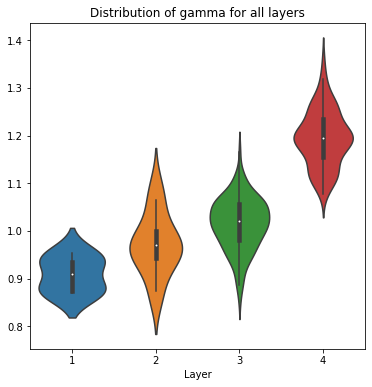

In [ ]:
plt.figure(figsize=(6, 6))
sns.violinplot(x=df['Layer'], y=list(df['Value']))
plt.title('Distribution of gamma for all layers')
plt.show()

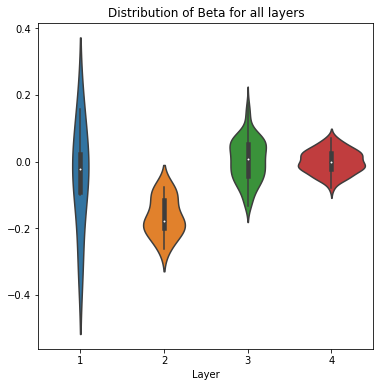

In [ ]:
plt.figure(figsize=(6, 6))
sns.violinplot(x=df['Layer'], y=list(df1['Value']))
plt.title('Distribution of Beta for all layers')
plt.show()

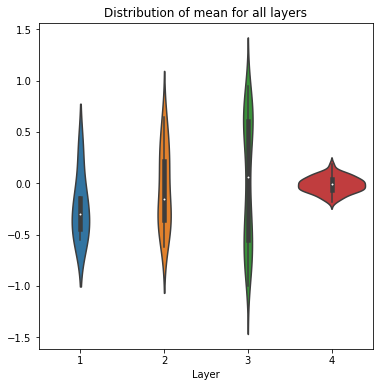

In [ ]:
plt.figure(figsize=(6, 6))
sns.violinplot(x=df['Layer'], y=list(df2['Value']))
plt.title('Distribution of mean for all layers')
plt.show()

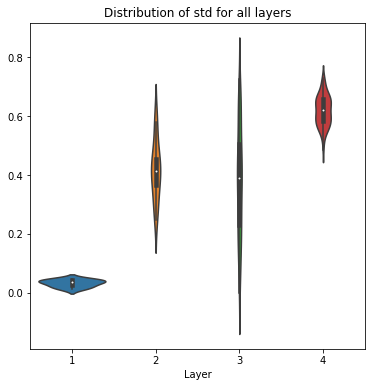

In [ ]:
plt.figure(figsize=(6, 6))
sns.violinplot(x=df['Layer'], y=list(df3['Value']))
plt.title('Distribution of std for all layers')
plt.show()

In [ ]:
a = model.evaluate(x_train, y_train)
b = model.evaluate(x_test, y_test)
c = model1.evaluate(x_train, y_train)
d = model1.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 148us/step


In [ ]:
print('Train performance of 1st model' ,a[1])
print('Train loss of 1st model' ,a[0])
print('Test performance of 1st model' ,b[1])
print('Test loss of 1st model' ,b[0])
print('Train performance of 2nd model' ,c[1])
print('Train loss of 2nd model' ,c[0])
print('Test performance of 2nd model' ,d[1])
print('Test loss of 2nd model' ,d[0])

Train performance of 1st model 0.988183319568634
Train loss of 1st model 0.03505929963202604
Test performance of 1st model 0.9797999858856201
Test loss of 1st model 0.07374759599595564
Train performance of 2nd model 0.9937999844551086
Train loss of 2nd model 0.017289344598793346
Test performance of 2nd model 0.9842000007629395
Test loss of 2nd model 0.05603499094339786


Train, test accuracy and loss improved after using batch initialization for the input layer. 

4) Train the network without batch normalization but this time use dropout. For hidden layers use dropout
probability of 0.5 and for input layer take it to be 0.2 Compare test accuracy using dropout to test
accuracy obtained using batch normalization in part 2 and 3.

In [ ]:
model2 = Sequential()

model2.add(layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(28,28,1)))
model2.add(Dropout(0.2))
model2.add(MaxPooling2D(pool_size = 2, strides = 2))
model2.add(Dropout(0.5))
model2.add(layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh'))
model2.add(Dropout(0.5))
model2.add(MaxPooling2D(pool_size = 2, strides = 2))
model2.add(Dropout(0.5))
model2.add(layers.Flatten())
model2.add(layers.Dense(120, activation='tanh'))
model2.add(Dropout(0.5))
model2.add(layers.Dense(84, activation='tanh'))
model2.add(Dropout(0.5))
model2.add(layers.Dense(10, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = model2.fit(x=x_train,y=y_train, epochs=10, batch_size=128, verbose=1)
test_score = model2.evaluate(x_test, y_test)
print('Test loss {:.4f}, accuracy {:.2f}%'.format(test_score[0], test_score[1] * 100))

Epoch 1/10
60000/60000 [==============================] - 7s 121us/step - loss: 1.1371 - accuracy: 0.6150
Epoch 2/10
60000/60000 [==============================] - 5s 82us/step - loss: 0.5839 - accuracy: 0.8138
Epoch 3/10
60000/60000 [==============================] - 5s 82us/step - loss: 0.4886 - accuracy: 0.8455
Epoch 4/10
60000/60000 [==============================] - 5s 82us/step - loss: 0.4442 - accuracy: 0.8633
Epoch 5/10
60000/60000 [==============================] - 5s 82us/step - loss: 0.4113 - accuracy: 0.8717
Epoch 6/10
60000/60000 [==============================] - 5s 82us/step - loss: 0.3991 - accuracy: 0.8769
Epoch 7/10
60000/60000 [==============================] - 5s 83us/step - loss: 0.3857 - accuracy: 0.8821
Epoch 8/10
60000/60000 [==============================] - 5s 82us/step - loss: 0.3749 - accuracy: 0.8859
Epoch 9/10
60000/60000 [==============================] - 5s 82us/step - loss: 0.3640 - accuracy: 0.8896
Epoch 10/10
10000/10000 [=============================

The model performs worse than the previous two with a much lower test accuracy

5) Now train the network using both batch normalization and dropout. How does the performance (test
accuracy) of the network compare with the cases with dropout alone and with batch normalization
alone ? 

In [ ]:
model3 = Sequential()

model3.add(layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(28,28,1)))
model3.add(BatchNormalization(trainable=True))
model3.add(Dropout(0.2))
model3.add(MaxPooling2D(pool_size = 2, strides = 2))
model3.add(layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh'))
model3.add(Dropout(0.5))
model3.add(MaxPooling2D(pool_size = 2, strides = 2))
model3.add(layers.Flatten())
model3.add(layers.Dense(120, activation='tanh'))
model3.add(BatchNormalization(trainable=True))
model3.add(Dropout(0.5))
model3.add(layers.Dense(84, activation='tanh'))
model3.add(BatchNormalization(trainable=True))
model3.add(Dropout(0.5))
model3.add(layers.Dense(10, activation='softmax'))
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = model3.fit(x=x_train,y=y_train, epochs=10, batch_size=128, verbose=1)
test_score = model3.evaluate(x_test, y_test)
print('Test loss {:.4f}, accuracy {:.2f}%'.format(test_score[0], test_score[1] * 100))

Epoch 1/10
60000/60000 [==============================] - 8s 132us/step - loss: 0.7376 - accuracy: 0.7719
Epoch 2/10
60000/60000 [==============================] - 7s 113us/step - loss: 0.2730 - accuracy: 0.9174
Epoch 3/10
60000/60000 [==============================] - 7s 114us/step - loss: 0.2073 - accuracy: 0.9395
Epoch 4/10
60000/60000 [==============================] - 7s 112us/step - loss: 0.1733 - accuracy: 0.9501
Epoch 5/10
60000/60000 [==============================] - 7s 112us/step - loss: 0.1524 - accuracy: 0.9559
Epoch 6/10
60000/60000 [==============================] - 7s 114us/step - loss: 0.1358 - accuracy: 0.9615
Epoch 7/10
60000/60000 [==============================] - 7s 112us/step - loss: 0.1267 - accuracy: 0.9631
Epoch 8/10
60000/60000 [==============================] - 7s 113us/step - loss: 0.1238 - accuracy: 0.9652
Epoch 9/10
60000/60000 [==============================] - 7s 115us/step - loss: 0.1193 - accuracy: 0.9657
Epoch 10/10
10000/10000 [=====================

The model has the third best performance of the models trained above. It performed better than dropout alone but worse than the models where dropout was not used.

## Problem 4

1) Assume that total budget for number of hidden units we can have in the network is 512. Train a 1,
2, and 3 hidden layers feedforward neural network to learn the regression function. For each neural
network you can consider a different number of hidden units per hidden layer so that the total number
of hidden units does not exceed 512. We would recommend to work with 16, 32, 64, 128, 256, 512,
hidden units per layer. So if there is only one hidden layer you can have at most 512 units in that layer.
If there are two hidden layers, you can have any combination of hidden units in each layer, e.g., 16 and
256, 64 and 128, etc. such that the total is less than 512. Plot the RMSE (Root Mean Square Error)
on test set for networks with different number of hidden layers as a function of total number of hidden
units. If there are more than one network with the same number of hidden units (say a two hidden
layer with 16 in first layer and 128 in second layer and another network with 128 in first layer and 16 in
second) you will use the average RMSE. So you will have a figure with three curves, one each for 1, 2,
and 3 layer networks, with x-axis being the total number of hidden units. Also plot another curve but
with the x-axis being the number of parameters (weights) that you need to learn in the network.

In [4]:
x1= np.random.uniform(-512, 512,100000)
x2= np.random.uniform(-512, 512,100000)
X= np.array([x1,x2]).T
f = -(x2+47)*np.sin(np.sqrt(abs(x1/2+x2+47)))-x1*np.sin(np.sqrt(abs(x1-x2-47)))
g = f+ np.random.normal(0,0.3,100000)
X_train, X_test, y_train, y_test = train_test_split(X,g, test_size=0.20, random_state=1)
sgd=keras.optimizers.SGD(learning_rate=0.01, nesterov=True)
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
activation = 'relu'
rmse=[]
parameters=[]
tl=[]

### 1 layer models

In [ ]:
rmse1=[]
ls=[128,256,512]
for i in ls:
  model = Sequential()
  model.add(Dense(15, input_shape=(2,), activation=activation))
  model.add(Dense(i,activation=activation))
  model.add(Dense(1))
  model.compile(optimizer=sgd,loss=root_mean_squared_error,metrics=[root_mean_squared_error])
  start= time.time()
  hist = model.fit(x=X_train,y=y_train, epochs=2000, batch_size=1000, verbose=0)
  end=time.time()
  tt=end-start
  rms = mean_squared_error(y_test, model.predict(X_test), squared=False)
  rmse1.append(rms)
  rmse.append(rms)
  tl.append(tt)
  parameters.append(model.count_params())

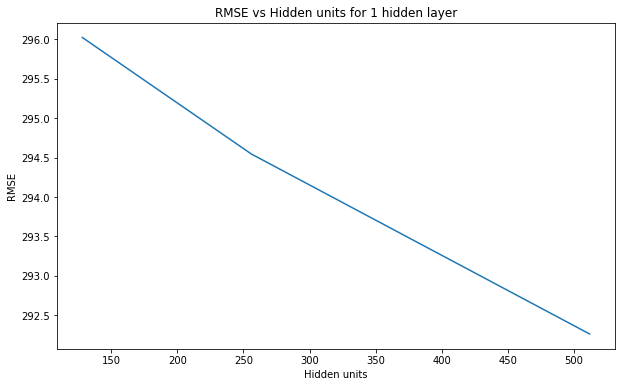

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(ls,rmse1)
plt.xlabel('Hidden units')
plt.ylabel('RMSE')
plt.title('RMSE vs Hidden units for 1 hidden layer')
plt.show()

### 2 layer models

In [ ]:
ls2=[[256,256],[128,256],[256,128],[64,256],[256,64],[64,128]]
units=np.sum(ls2,axis=1)
rmse2=[]
for l in ls2:
  model = Sequential()
  model.add(Dense(20, input_shape=(2,), activation=activation))
  model.add(BatchNormalization(trainable=True))
  model.add(Dense(l[0],activation=activation))
  model.add(BatchNormalization(trainable=True))
  model.add(Dense(l[1],activation=activation))
  model.add(Dense(1))
  model.compile(optimizer=sgd,loss=root_mean_squared_error,metrics=[root_mean_squared_error])
  start=time.time()
  hist = model.fit(x=X_train,y=y_train, epochs=2000, batch_size=1000, verbose=0)
  end=time.time()
  tt=end-start
  rms = mean_squared_error(y_test, model.predict(X_test), squared=False)
  rmse2.append(rms)
  rmse.append(rms)
  tl.append(tt)
  parameters.append(model.count_params())

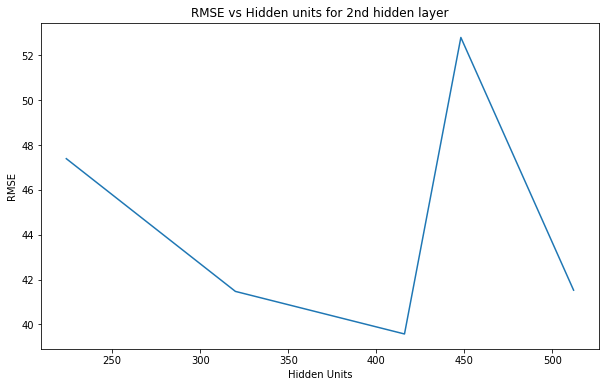

In [40]:
a=[]
for x,y in zip(rmse2,units):
  a.append((y,x))

d = defaultdict(list)
result = {}
for key, value in a:
   result.setdefault(key, []).append(value)
D = {}
for k,v in result.items():
    # v is the list of grades for student k
    D[k] = sum(v)/ float(len(v))
lists = sorted(D.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.xlabel('Hidden Units')
plt.ylabel('RMSE')
plt.title('RMSE vs Hidden units for 2nd hidden layer')
plt.show()

### 3 layer models

In [ ]:
ls2=[[128,128,256],[32,128,256],[64,128,128],[64,256,128],[256,128,64],[32,64,128]]
units=np.sum(ls2,axis=1)
rmse3=[]
for l in ls2[5:]:
  model = Sequential()
  model.add(Dense(20, input_shape=(2,), activation=activation))
  model.add(BatchNormalization(trainable=True))
  model.add(Dense(l[0],activation=activation))
  model.add(BatchNormalization(trainable=True))
  model.add(Dense(l[1],activation=activation))
  model.add(BatchNormalization(trainable=True))
  model.add(Dense(l[2],activation=activation))
  model.add(Dense(1))
  model.compile(optimizer=sgd,loss=root_mean_squared_error,metrics=[root_mean_squared_error])
  start=time.time()
  hist = model.fit(x=X_train,y=y_train, epochs=2000, batch_size=1000, verbose=1)
  end=time.time()
  tt=end-start
  rms = mean_squared_error(y_test, model.predict(X_test), squared=False)
  rmse3.append(rms)
  rmse.append(rms)
  tl.append(tt)
  parameters.append(model.count_params())

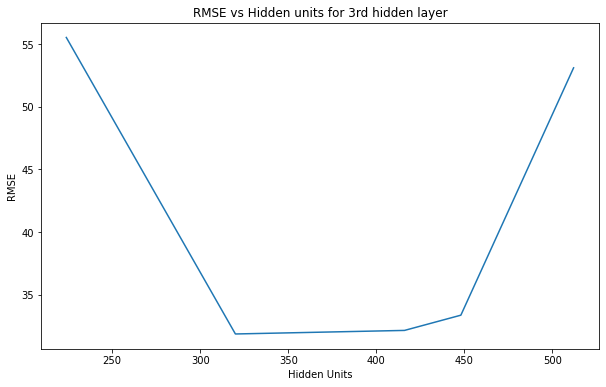

In [39]:
a=[]
for x,y in zip(rmse3,units):
  a.append((y,x))

d = defaultdict(list)
result = {}
for key, value in a:
   result.setdefault(key, []).append(value)
D = {}
for k,v in result.items():
    # v is the list of grades for student k
    D[k] = sum(v)/ float(len(v))
lists = sorted(D.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.xlabel('Hidden Units')
plt.ylabel('RMSE')
plt.title('RMSE vs Hidden units for 3rd hidden layer')
plt.show()

2) Comment on the tradeoff between number of parameters and RMSE as you go from deeper (3 hidden layers) to shallow networks (1 hidden layer). Also measure the wall clock time for training each configuration and plot training time vs number of parameters. Do you see a similar tradeoff in training time
?

In [58]:
parameters1=sorted(parameters[:3])
parameters2=sorted(parameters[3:9])
parameters3=sorted(parameters[9:])
t1 = [x for _, x in sorted(zip(parameters1, tl[:3]))]
t2 = [x for _, x in sorted(zip(parameters2, tl[3:9]))]
t3 = [x for _, x in sorted(zip(parameters3, tl[9:]))]
r1 = [x for _, x in sorted(zip(parameters, rmse1))]
r2 = [x for _, x in sorted(zip(parameters, rmse2))]
r3 = [x for _, x in sorted(zip(parameters, rmse3))]

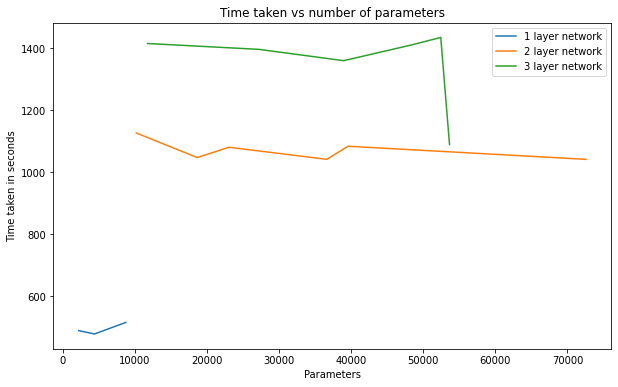

In [65]:
plt.figure(figsize=(10, 6))
plt.plot(parameters1, t1 ,label='1 layer network')
plt.plot(parameters2, t2 ,label='2 layer network')
plt.plot(parameters3, t3,label='3 layer network')
plt.xlabel('Parameters')
plt.ylabel('Time taken in seconds')
plt.title('Time taken vs number of parameters')
plt.legend()
plt.show()

1 layer - The time taken fell and rose again as the number of parameters increased

2 layer - The time taken remained constant as the number of parameters increased

3 layer - The time taken fell, rose and fell again 

Note - As the models were trained on Google Colab, this analysis may have been hampered by the different GPUs provided. 

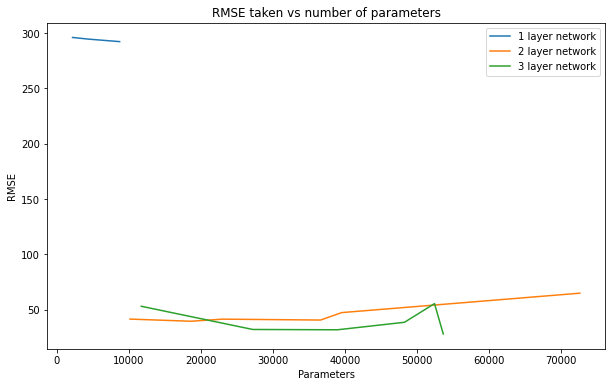

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(parameters1, r1,label='1 layer network')
plt.plot(parameters2, r2,label='2 layer network')
plt.plot(parameters3, r3,label='3 layer network')
plt.xlabel('Parameters')
plt.ylabel('RMSE')
plt.title('RMSE taken vs number of parameters')
plt.legend()
plt.show()

1 layer - The RMSE fell as the number of parameters were increased

2 layer - The RMSE rose as the number of parameters increased. This could be indicative of overfitting. 

3 layer - The RMSE fell until an optimum point was obtained which gave the 2nd best performance of all models. After the RMSE rose again suggesting overfitting before falling to the lowest value which gave me the best performance on the test data. 

### Performance evaluation of the models

In [38]:
print('Actual Value: ', y_test[0])
print('Predicted Value: ', model.predict(X_test)[0][0])

Actual Value:  -332.2613041838078
Predicted Value:  -326.53973


Below we can observe the difference between the actual and predicted value from the model. Here I am using the 3 layer model with node division [32,64,128]. We can see the model performs pretty well despite the smaller number of hidden nodes used which shows the learning capabilities of deep learning networks